# F1 EDA
#### PART 1: 

Here I answer some questions regarding drivers, races, and seasons.

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExNWl6ajhnaDU4aHVteGpmamk2Z3BkdXd3NDFwY3BybG9uMHB2MzZtcSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/sA50TO4Ew7QXu/giphy.gif")

## 1) Importing Packages and Data

In [8]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

np.random.seed(1994)
plt.figure(dpi=150)

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

In [9]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "1_API_Requests_Ergast.py"

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")
QualifyingDF=pd.read_csv(path+"QualifyingDF.csv")
LapsDF=pd.read_csv(path+"LapsDF.csv")
PitsDF=pd.read_csv(path+"PitsDF.csv")

C:\Users\gabri\AppData\Local\Temp\ipykernel_28124\478565046.py:8: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  LapsDF=pd.read_csv(path+"LapsDF.csv")


## 2) Data Preprocessing

In [10]:
# Apply the data preprocessing for each df using a function stored in the repo. 
# This is done this way so the preprocessing is consistent throughout all notebooks.
ResultsDF=F1_Preprocessing.preprocess_Ergast_Results(ResultsDF,OneHotEncoder=False,HandleNulls=False) 
LapsDF=F1_Preprocessing.preprocess_Ergast_Laps(LapsDF)
PitsDF=F1_Preprocessing.preprocess_Ergast_Pits(PitsDF)

In [11]:
# Merging features between dfs

# Laps and Pits
Laps_Pits=LapsDF.merge(PitsDF[["season","round","driverid","pit_stop_lap_number","pit_stop_time","pit_stop_duration_in_milliseconds","pit_stop_number"]].drop_duplicates(),
                   left_on=["driverid","season","round","current_lap_number"],
                   right_on=["driverid","season","round","pit_stop_lap_number"],how="left")


# We only have information of the pit stops from 2012, so Laps_Pits will have instances from 2012 or later
Laps_Pits=Laps_Pits[Laps_Pits["season"]>=2012].drop_duplicates()


# Merging with Results df
SelectedResults=ResultsDF[['final_position', 'final_points', 'final_grid', 'final_laps', 'final_status', 'driverid','driver.nationality', 'constructor.constructorid', 'constructor.nationality', 'race_time.millis','fastestlap.rank', 'fastestlap.lap','fastestlap.time.time', 'fastestlap.averagespeed.units','fastestlap.averagespeed.speed', 'season', 'round','fastestlap.time.in_milliseconds', 'season-round','circuit.circuitid_encoded', 'constructor.constructorid_encoded','driverid_encoded']].drop_duplicates()

Laps_Pits_Results=pd.merge(Laps_Pits,SelectedResults,on=["driverid","season","round"],how="left")

In [12]:
# Adding extra features

#Feature created to indicated if the lap is the fastest or not
Laps_Pits_Results['IsFastestLap']=np.where(Laps_Pits_Results['current_lap_number'] == Laps_Pits_Results['fastestlap.lap'], 1, 0)
Laps_Pits_Results['IsPitStopLap']=np.where(Laps_Pits_Results['current_lap_number'] == Laps_Pits_Results['pit_stop_lap_number'], 1, 0)

## 3) Answering some questions with EDA

### A. How fast are the cars now?


##### >>> Distributon of the fastest lap per round (race) per driver from season 2014 to 2024 

In this graph we can see the fastest lap, per race, per driver, and per season. The label at the bottom of each season shows the name of the driver who did the fastest lap of the year and the name of the circuit of the fastest lap.

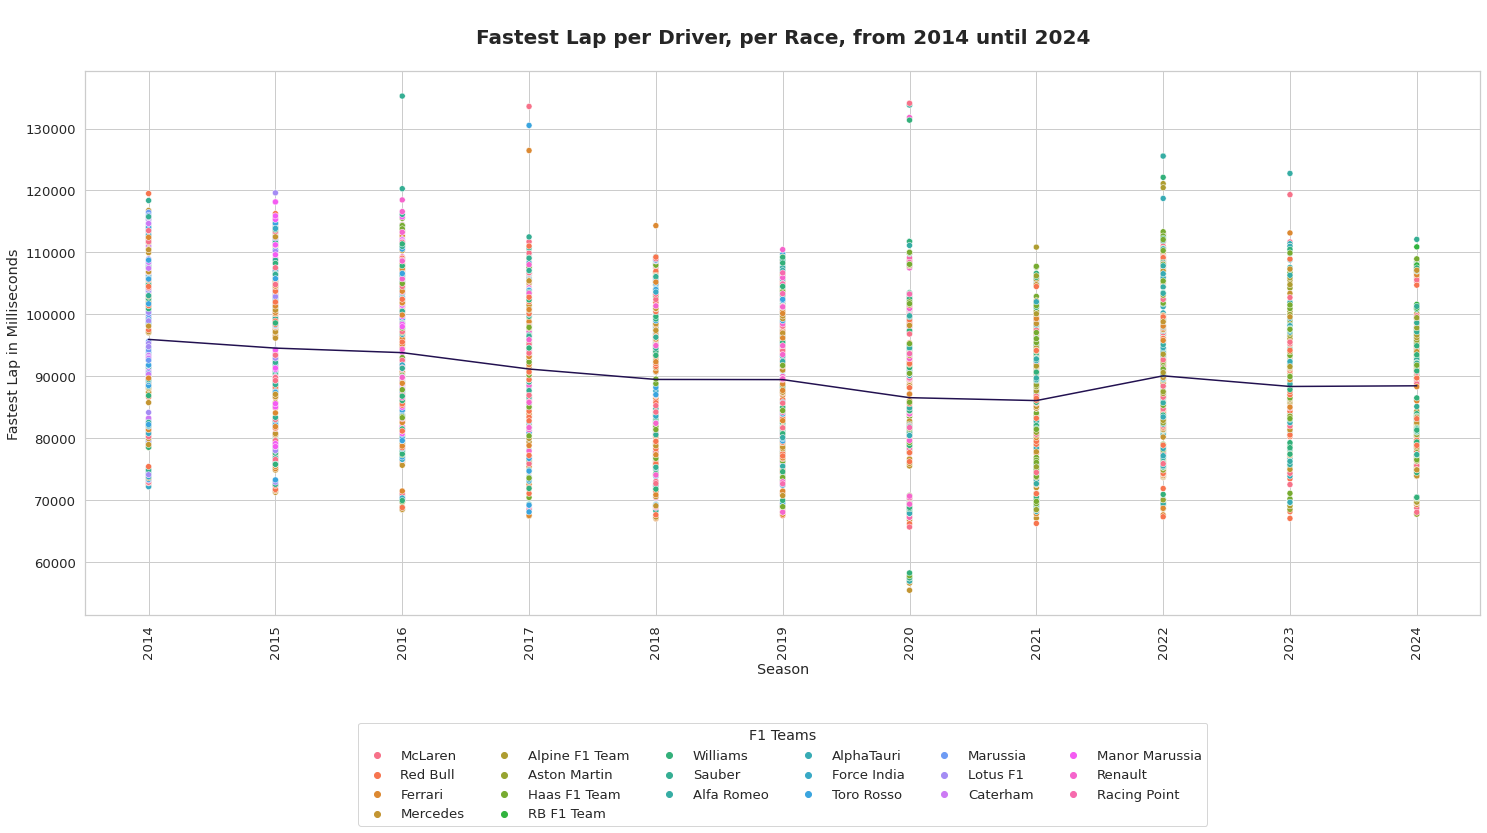

In [13]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2014
DF=ResultsDF[(ResultsDF["season"]>=From_Season)&(ResultsDF["fastestlap.time.in_milliseconds"]<140000)] #filter for viz reasons

#Fastest lap per driver per season
fastest_lap_per_season=DF.groupby(["season"])["fastestlap.time.in_milliseconds"].min().reset_index().rename(columns={"fastestlap.time.in_milliseconds":"fastestlap_season"})
labels_df=ResultsDF.merge(fastest_lap_per_season,on="season",how="left")
labels_df=labels_df[labels_df["fastestlap.time.in_milliseconds"]==labels_df["fastestlap_season"]].reset_index()[["driverid","circuit.circuitname","fastestlap.averagespeed.speed","season"]].drop_duplicates()


#Plot
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(x="season", y="fastestlap.time.in_milliseconds",hue='constructor.name',ci=None,estimator="min",markers=True,data=DF)
sns.lineplot(x="season", y="fastestlap.time.in_milliseconds",estimator="mean",ci=None,data=DF)

ax.set(xlabel="Season", ylabel="Fastest Lap in Milliseconds")
ax.set_title("\n Fastest Lap per Driver, per Race, from 2014 until 2024 \n",fontsize=20,fontweight='bold')

seasons = DF["season"].unique()
ax.set_xticks(seasons)
ax.set_xticklabels(seasons, rotation=90)  
ax.locator_params(axis="x", nbins=len(seasons))

ax.legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', title="F1 Teams", ncol=6)

# Annotattions:
for driver, circuit, time, season in labels_df.to_numpy():
    label = f"{driver}\n{circuit}"
    ax.annotate(label, 
                (season, time), 
                textcoords="offset points", 
                xytext=(0, -25),
                ha='center')

plt.show()


The above graph is good to give an idea of how fast the cars run. We can see that the cars are running slightly faster and that the Red Bull Ring (Austria) is the one with the shortest lap of the calendar. 

In the graph below we can see the fastest lap by driver and filter by circuit using the legend.

IMPORTANT: This is a Plotly graph, it can be seen when downloading the notebook, not in GitHub.

In [14]:
# Filter data
From_Season = 2014
DF = ResultsDF[(ResultsDF["season"] >= From_Season)]

fig = px.scatter(DF, x='season', y='fastestlap.time.in_milliseconds',color='circuit.circuitname',hover_data=['constructor.name','driverid'])

# Update layout
fig.update_layout(xaxis_title="Season",
                  yaxis_title="Fastest Lap Time (Milliseconds)",
                  title_text=f"Fastest Laps by circuit (2014-2024)",
                  title_font=dict(size=24, color='black', weight='bold'), 
                  title_x=0.5,
                  legend_title="Circuit")

# Show the interactive plot
fig.show()


##### >>> Fastest Lap per Circuit per Team in 2023

Below is a comparison of the fastest lap by constructor and circuit in 2023. As we saw before, the Red Bull Ring (Austria) is the one with the fastest lap, second after it comes Autódromo José Carlos Pace (Brazil).

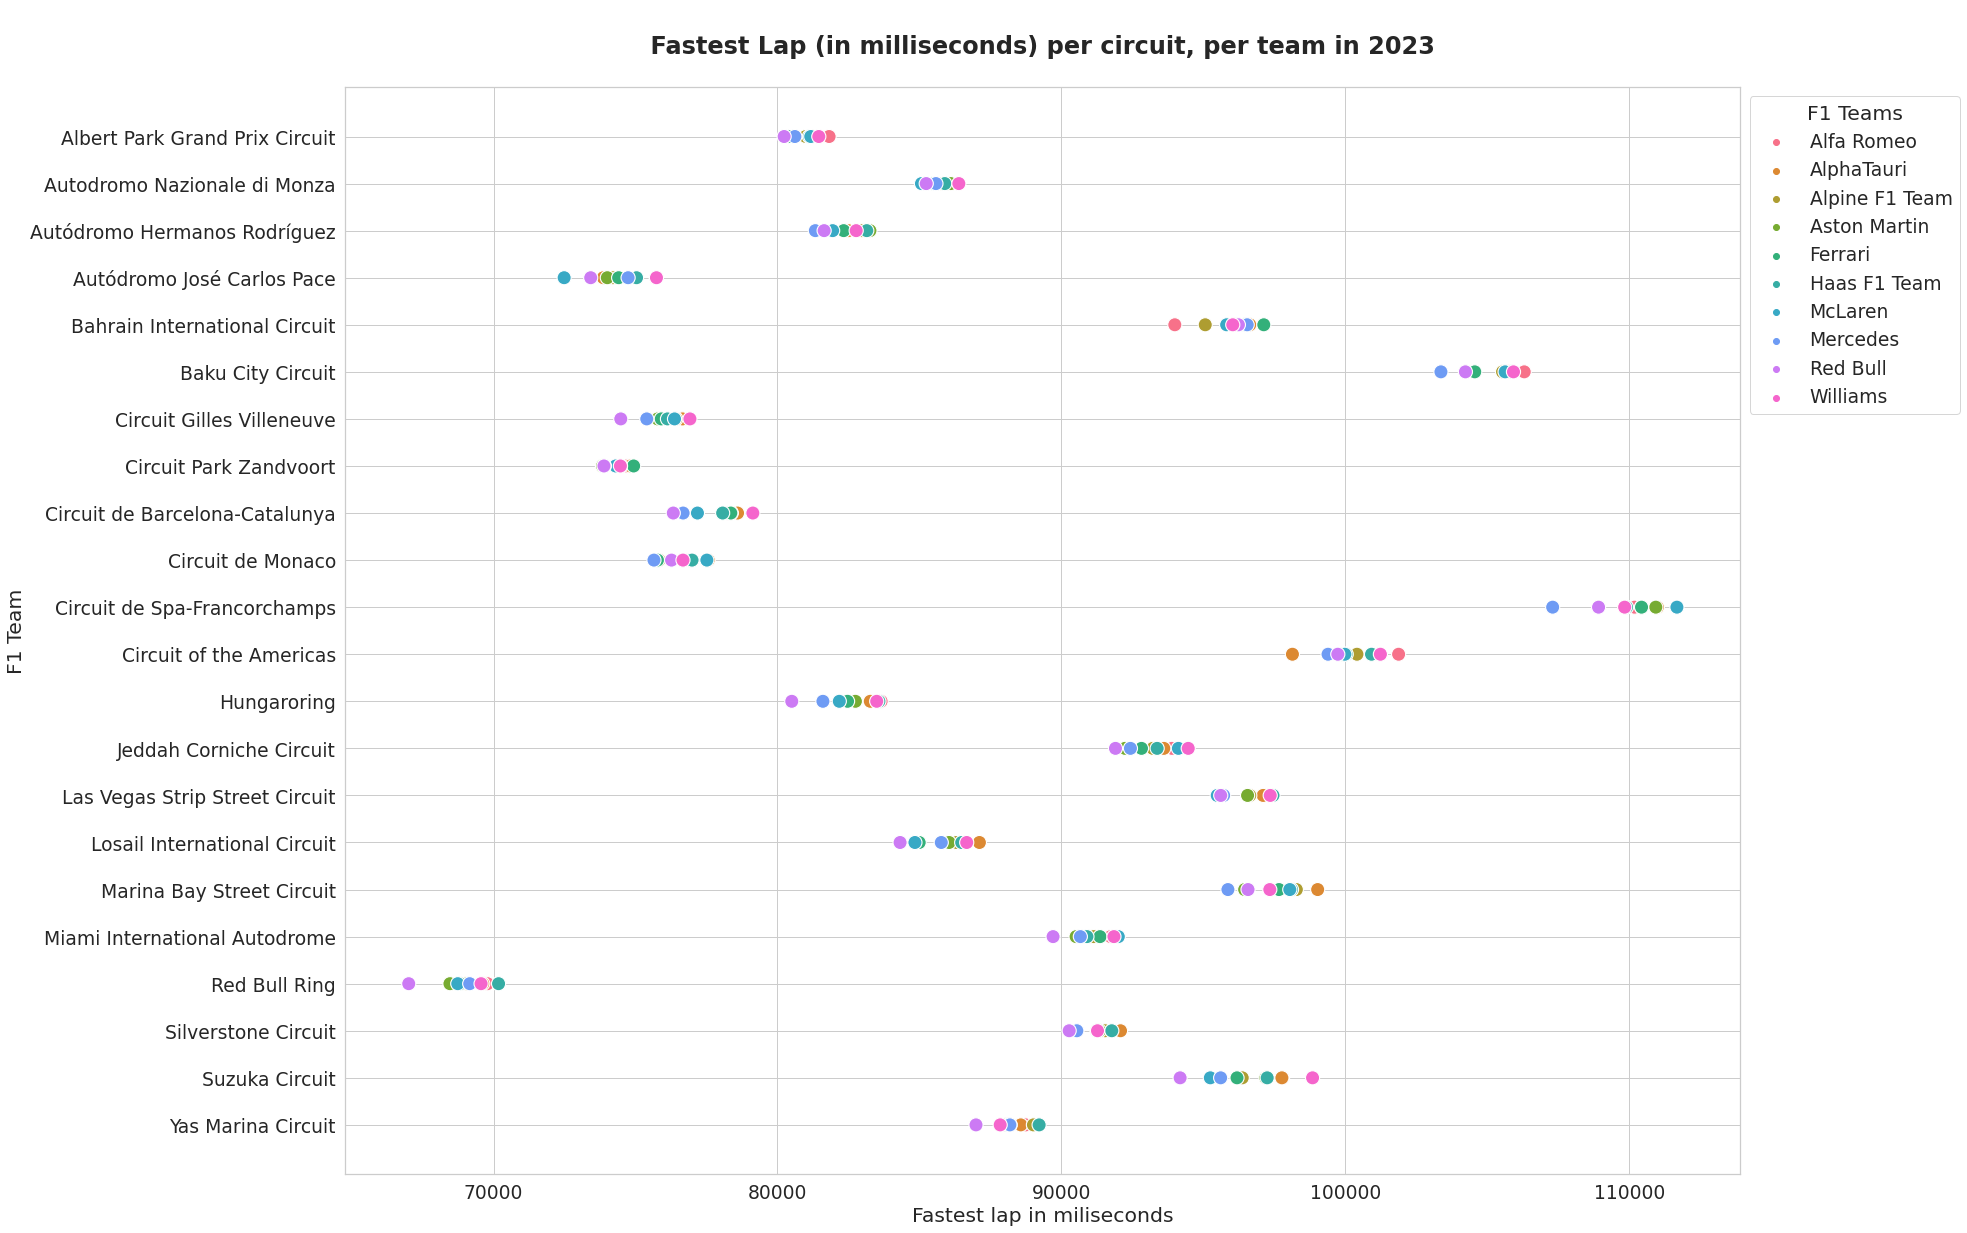

In [15]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.7,font="DejaVu Sans")

From_Season=2023
DF=ResultsDF[(ResultsDF["season"]==From_Season)].groupby(['circuit.circuitname','constructor.name']).agg({"fastestlap.time.in_milliseconds":"min"}).reset_index() #filter for viz reasons

fig, ax = plt.subplots(figsize=(25, 20))

sns.scatterplot(x="fastestlap.time.in_milliseconds", y='circuit.circuitname',hue='constructor.name',data=DF,s=200)
ax.set_title("\n Fastest Lap (in milliseconds) per circuit, per team in 2023 \n",fontsize=24,fontweight='bold')
ax.set(ylabel="F1 Team",xlabel="Fastest lap in miliseconds")

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title="F1 Teams", ncol=1)

plt.show()

##### >>> Top Speed per Race from 2014 to 2024 by Driver

This plot shows the top speed per race, per driver, for each season. It is important to note that the speed at which the cars run depends on the mechanical regulations set by the FIA each year. However, we observe that, in general, the average speed for the fastest laps per driver has shown an upward trend in recent years. Also, Monza is the circuit with the highest average speed each season for the last 10 years.

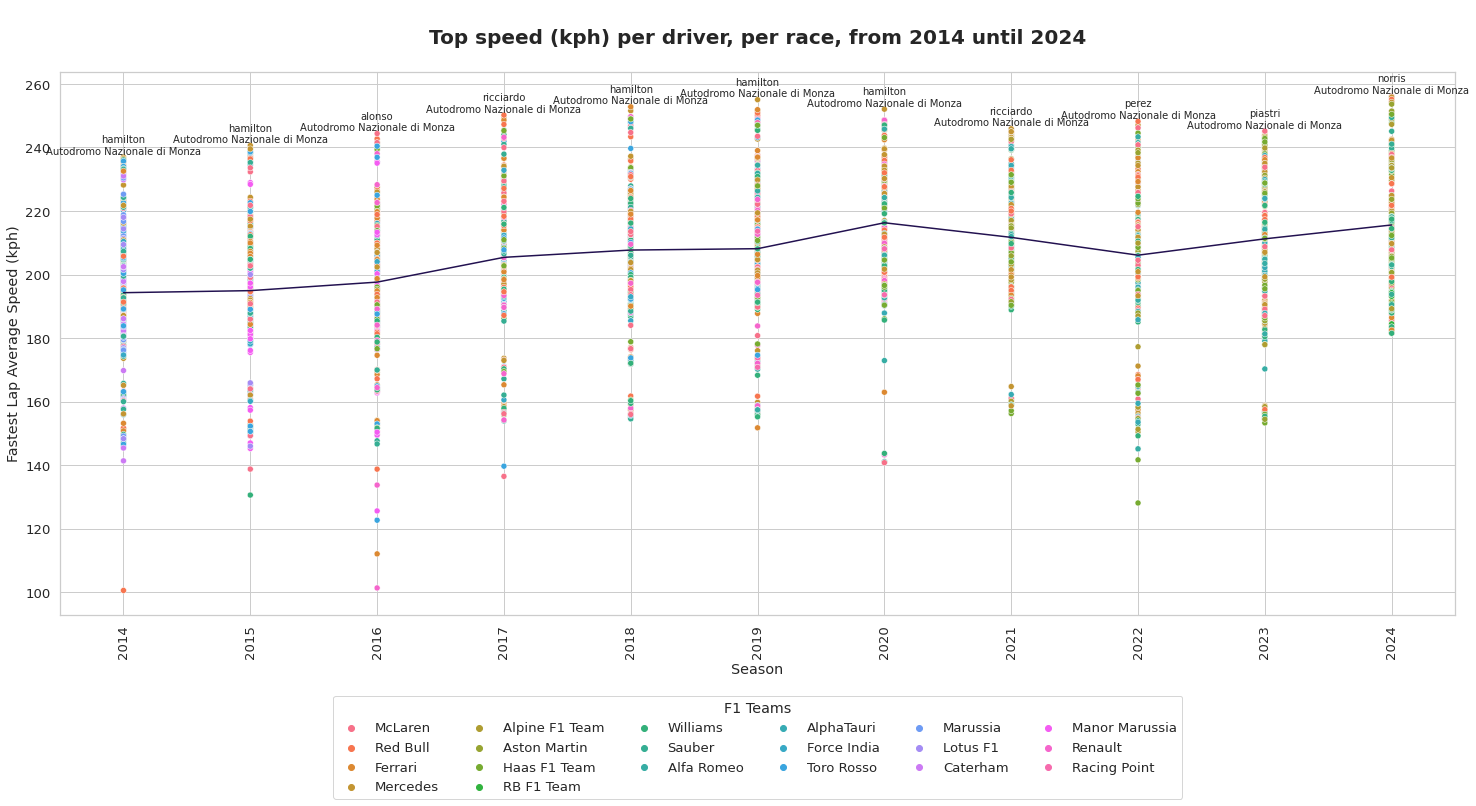

In [16]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2014
DF=ResultsDF[(ResultsDF["season"]>=From_Season)] #filter for viz reasons

#Fastest lap per driver per season
fastest_lap_per_season=DF.groupby(["season"])["fastestlap.averagespeed.speed"].max().reset_index().rename(columns={"fastestlap.averagespeed.speed":"fastestlap_season"})
labels_df=ResultsDF.merge(fastest_lap_per_season,on="season",how="left")
labels_df=labels_df[labels_df["fastestlap.averagespeed.speed"]==labels_df["fastestlap_season"]].reset_index()[["driverid","circuit.circuitname","fastestlap.averagespeed.speed","season"]].drop_duplicates()


#Plot
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(x="season", y="fastestlap.averagespeed.speed",hue='constructor.name',ci=None,estimator="max",markers=True,data=DF)
sns.lineplot(x="season", y="fastestlap.averagespeed.speed",estimator="mean",ci=None,data=DF)

ax.set(xlabel="Season", ylabel="Fastest Lap Average Speed (kph)")
ax.set_title("\n Top speed (kph) per driver, per race, from 2014 until 2024 \n",fontsize=20,fontweight='bold')

seasons = DF["season"].unique()
ax.set_xticks(seasons)
ax.set_xticklabels(seasons, rotation=90)  
ax.locator_params(axis="x", nbins=len(seasons))

ax.legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', title="F1 Teams", ncol=6)

# Annotattions:
for driver, circuit, time, season in labels_df.to_numpy():
    label = f"{driver}\n{circuit}"
    ax.annotate(label, 
                (season, time), 
                textcoords="offset points", 
                xytext=(0, 3),
                ha='center',
                fontsize=10)

plt.show()


##### >>> Top Speed Distribution by Year and Constructor from 2014 to 2024

These plots show the distribution of the speed of the fastest lap per race by circuit and year. Here we see that the speed has increased in the last years and that although some teams are faster than others, the distance in speed between them is not massive each year.

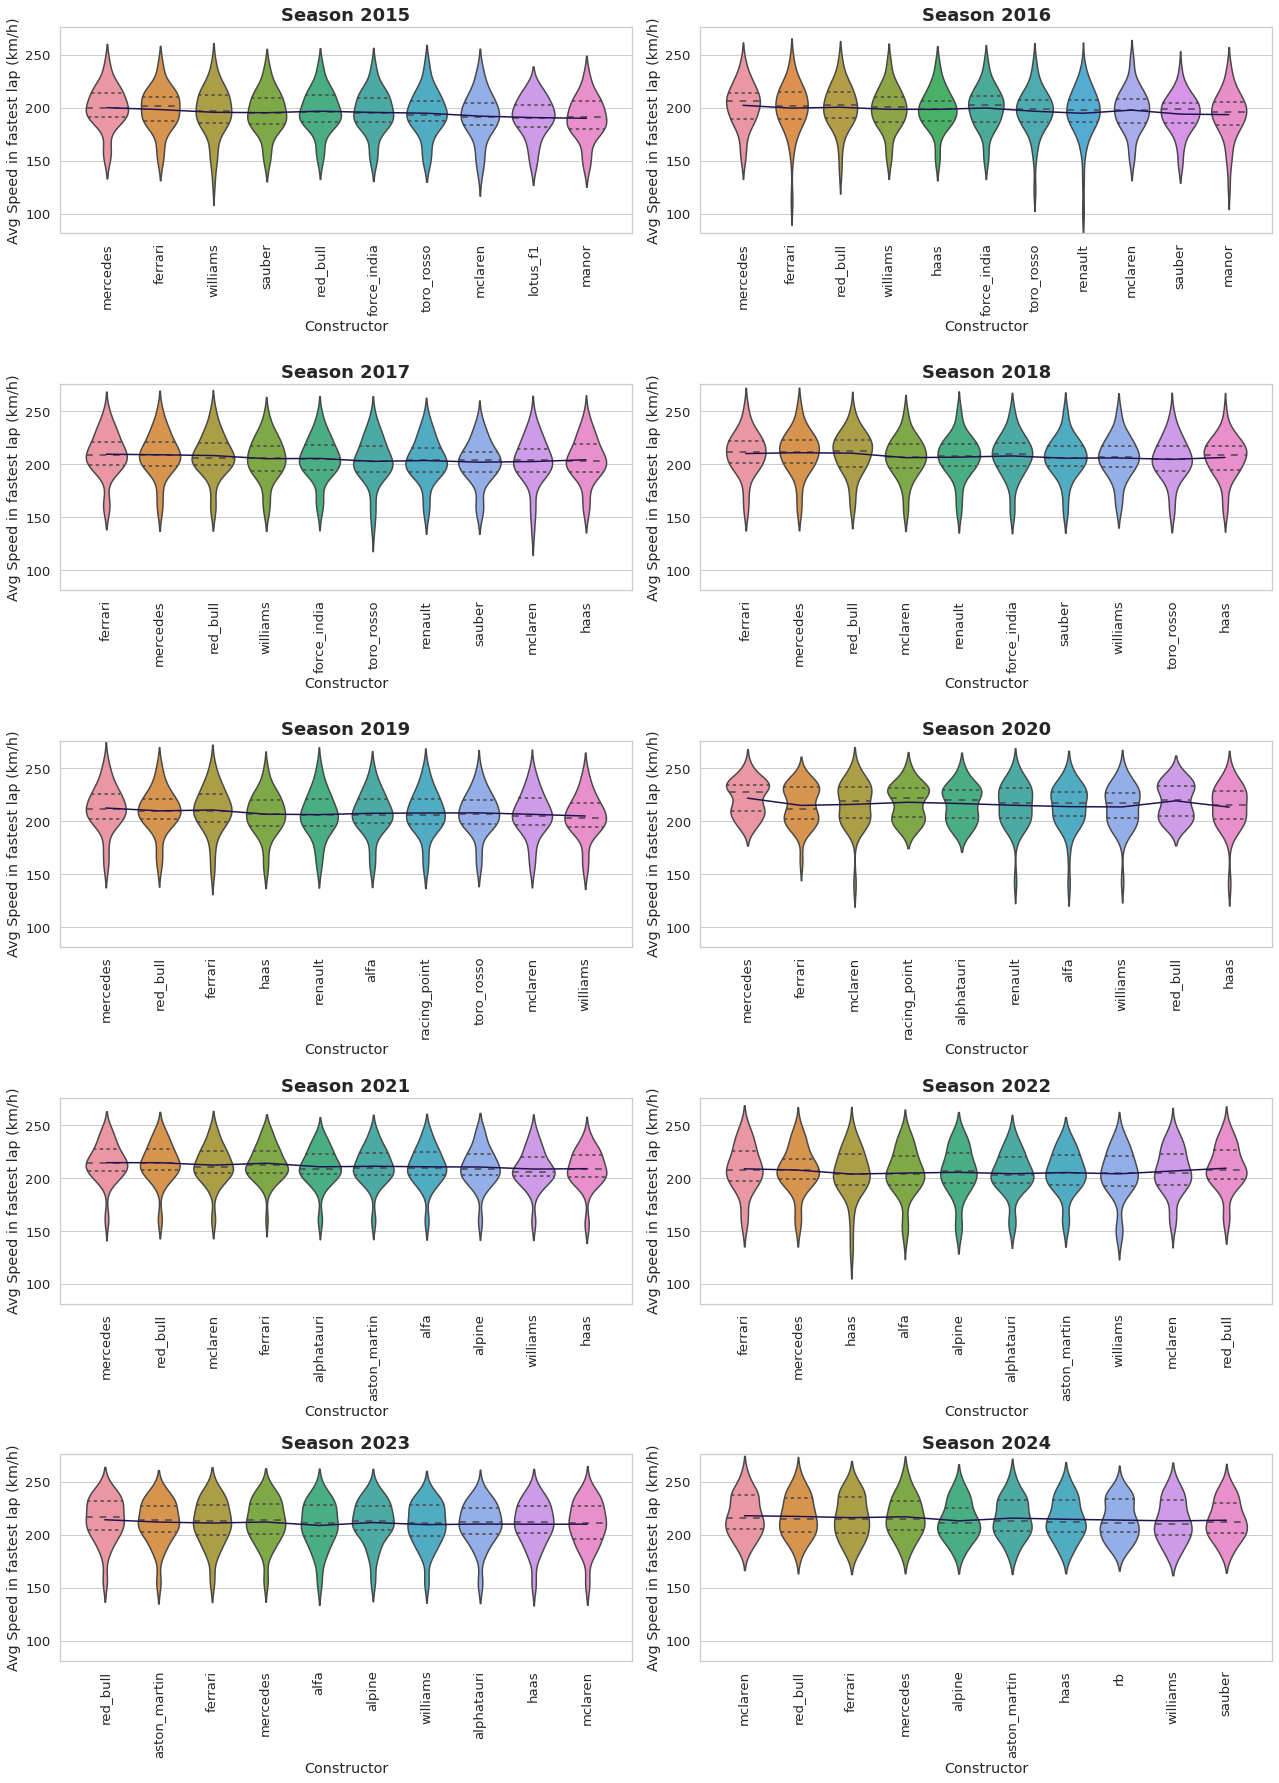

In [17]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2015
DF=ResultsDF[(ResultsDF["season"]>=From_Season)] #filter for viz reasons
cols,x,y=2,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(18, rows*5),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    sns.violinplot(x='constructor.constructorid', y='fastestlap.averagespeed.speed', data=DF[DF["season"] == year],inner='quart', ax=axs[y,x])
    sns.lineplot(estimator="mean",ci=None,x='constructor.constructorid', y='fastestlap.averagespeed.speed', data=DF[DF["season"] == year], ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_xlabel('Constructor')
    axs[y,x].set_ylabel('Avg Speed in fastest lap (km/h)')
    axs[y,x].set_xticklabels(axs[y, x].get_xticklabels(), rotation=90)
    axs[y,x].set_ylim(DF['fastestlap.averagespeed.speed'].min()-20, DF['fastestlap.averagespeed.speed'].max()+20)

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()

### B. Number of Wins, Points and Other Statistics of Drivers and Teams

##### >>> Podium positions by driver since 2020

Below we see that seasons 2020 and 2021 had mostly podiums from Max Verstappen, Hamilton and Bottas. The 2022 and 2024 seasons saw the presence of a higher variety of drivers in the podium.

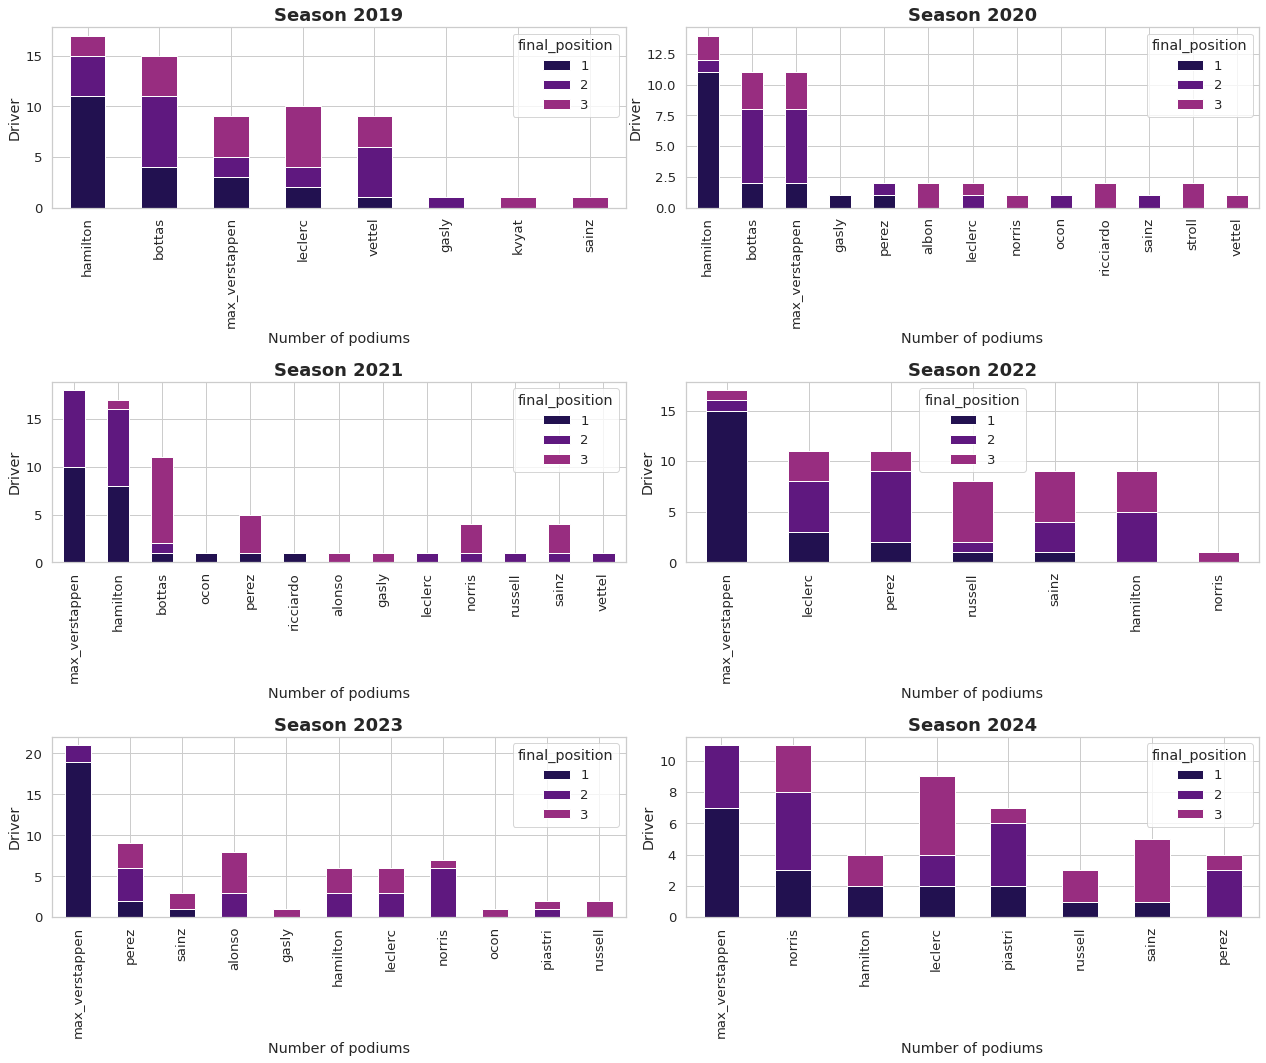

In [18]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019
DF=ResultsDF[(ResultsDF['final_position']<=3)&(ResultsDF["season"]>=From_Season)].groupby(['final_position',"driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Number"})

cols,x,y=2,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(18, rows*5),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    DF[DF["season"] == year].pivot(index="driverid",columns="final_position",values="Number").fillna(0).sort_values(by=1,ascending=False).plot(kind='bar', stacked=True,ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_xlabel('Number of podiums')
    axs[y,x].set_ylabel('Driver')
    axs[y,x].set_xticklabels(axs[y, x].get_xticklabels(), rotation=90)

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()


##### >>> Podium positions by team since 2020

In this timeframe, 2024 is the first season in which (until now) not Mercedes or Red Bull has the highest amount of podiums.

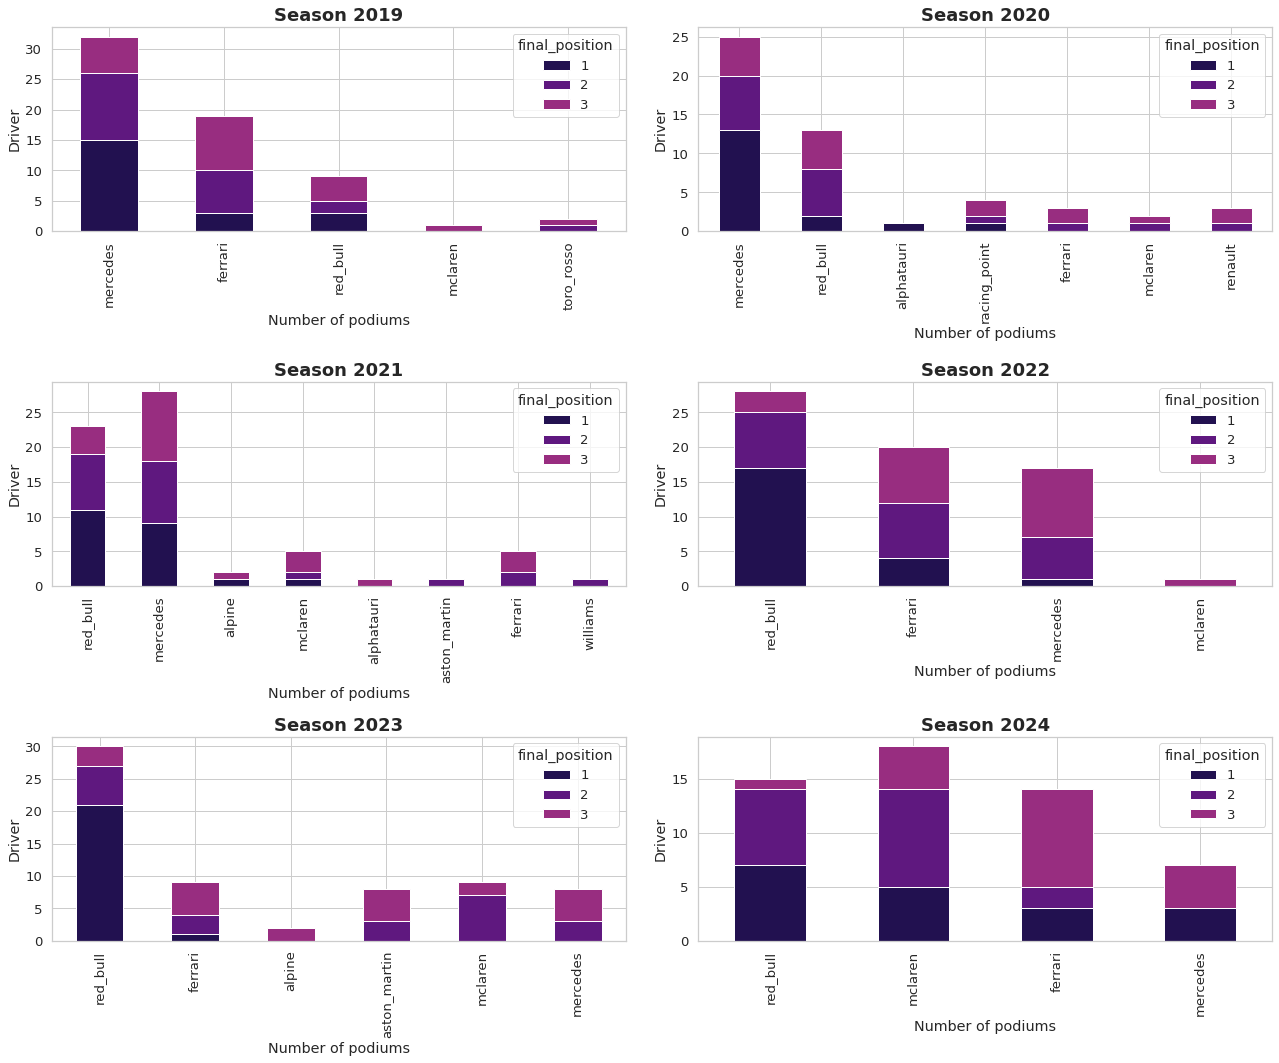

In [19]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019
DF=ResultsDF[(ResultsDF['final_position']<=3)&(ResultsDF["season"]>=From_Season)].groupby(['final_position',"constructor.constructorid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Number"})

cols,x,y=2,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(18, rows*5),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    DF[DF["season"] == year].pivot(index="constructor.constructorid",columns="final_position",values="Number").fillna(0).sort_values(by=1,ascending=False).plot(kind='bar', stacked=True,ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_xlabel('Number of podiums')
    axs[y,x].set_ylabel('Driver')
    axs[y,x].set_xticklabels(axs[y, x].get_xticklabels(), rotation=90)

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()


##### >>> Front row start distribution by driver since 2020

Here we see a similar distribution to the ones seen above. However, drivers like Leclerc , even though they perform great during Qualifying, this is not necesarily reflected in the final position of the race.

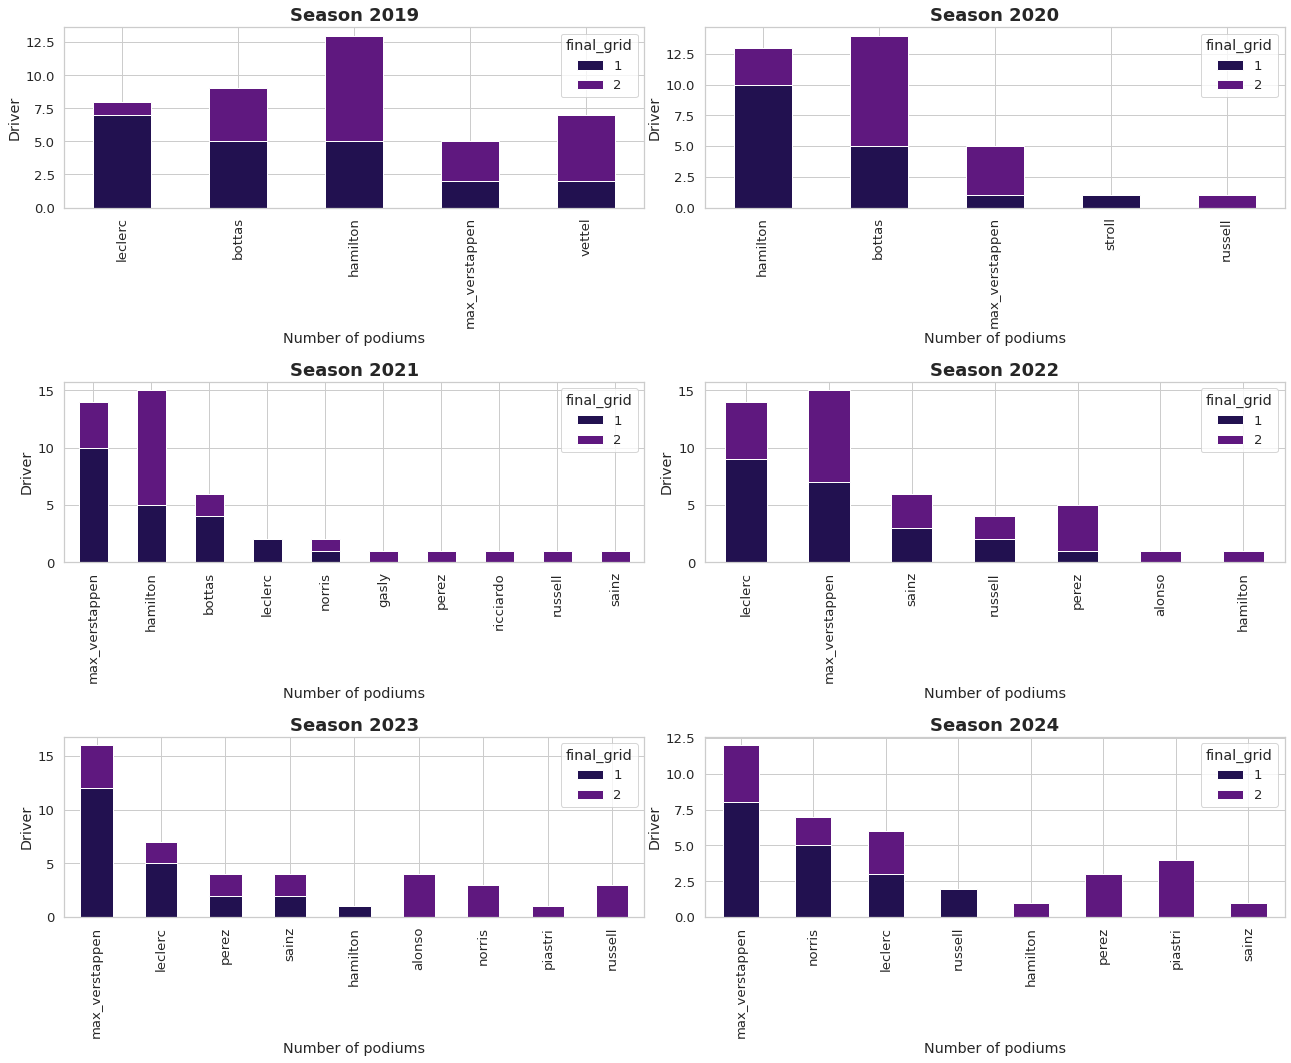

In [20]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019
DF=ResultsDF[(ResultsDF['final_grid'].isin([1,2]))&(ResultsDF["season"]>=From_Season)].groupby(['final_grid',"driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Number"})

cols,x,y=2,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(18, rows*5),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    DF[DF["season"] == year].pivot(index="driverid",columns="final_grid",values="Number").fillna(0).sort_values(by=1,ascending=False).plot(kind='bar', stacked=True,ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_xlabel('Number of podiums')
    axs[y,x].set_ylabel('Driver')
    axs[y,x].set_xticklabels(axs[y, x].get_xticklabels(), rotation=90)

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()


##### >>> Front row start distribution by team since 2020

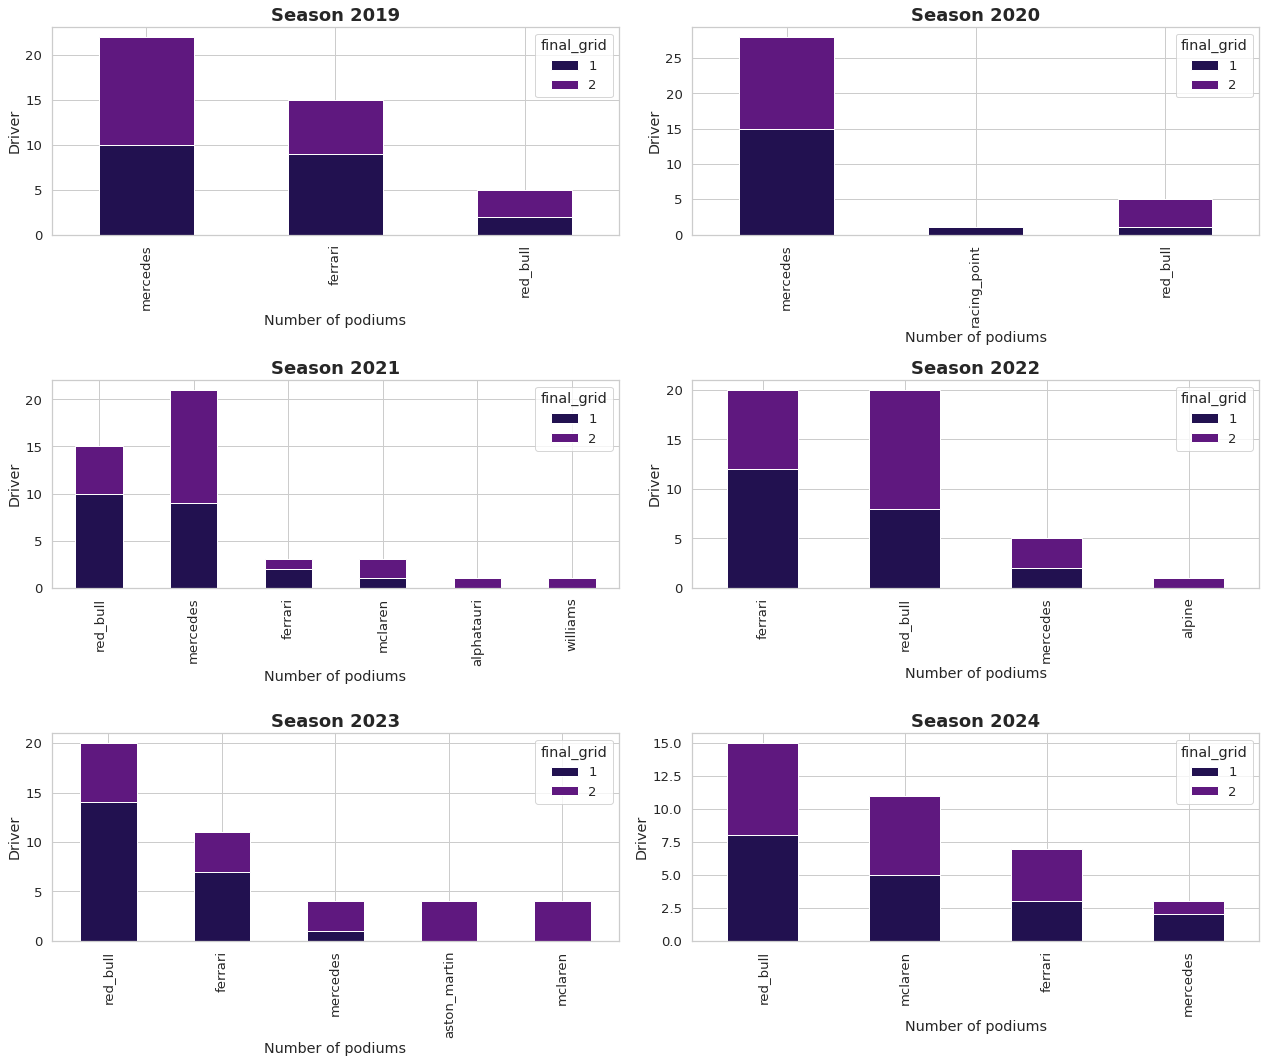

In [21]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019
DF=ResultsDF[(ResultsDF['final_grid'].isin([1,2]))&(ResultsDF["season"]>=From_Season)].groupby(['final_grid',"constructor.constructorid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Number"})

cols,x,y=2,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(18, rows*5),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    DF[DF["season"] == year].pivot(index="constructor.constructorid",columns="final_grid",values="Number").fillna(0).sort_values(by=1,ascending=False).plot(kind='bar', stacked=True,ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_xlabel('Number of podiums')
    axs[y,x].set_ylabel('Driver')
    axs[y,x].set_xticklabels(axs[y, x].get_xticklabels(), rotation=90)

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()


##### >>> % Wins when Starting in Front Position since 2020

Below we see the % of times the driver won when he started the race in front position and front row. Also, the % of times when each driver finished with a podium starting in the first 3 positions.

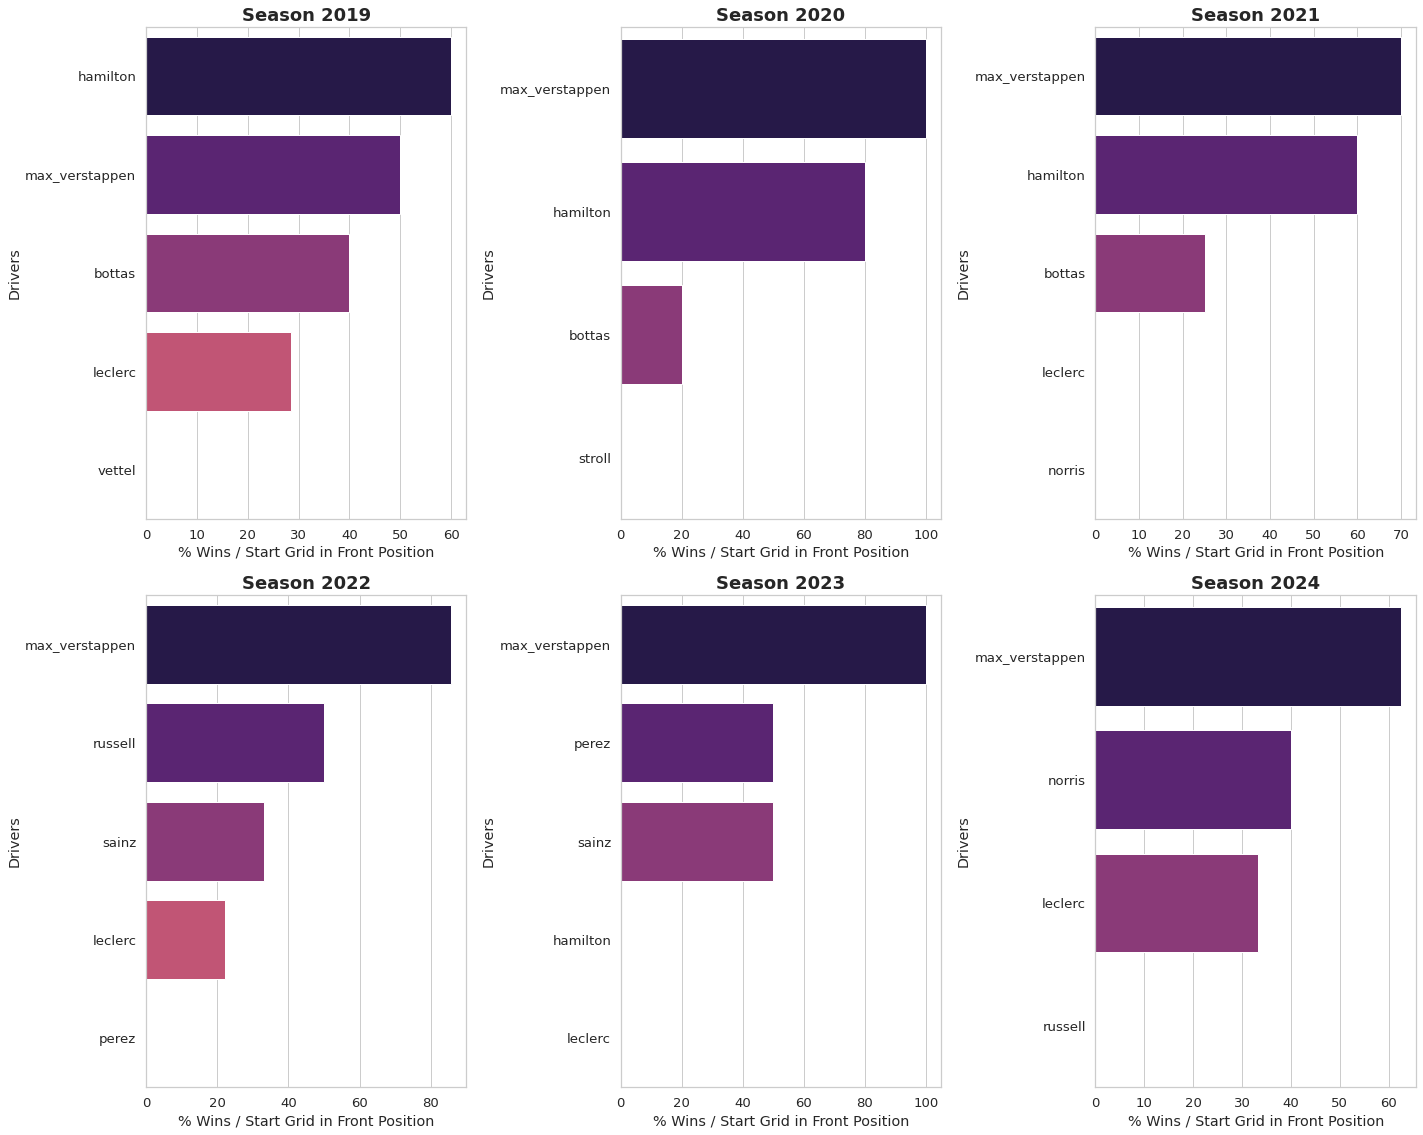

In [22]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019

DF1=ResultsDF[(ResultsDF['final_grid'].isin([1]))&(ResultsDF["season"]>=From_Season)].groupby(["driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"FrontRowTimes"})
DF2=ResultsDF[(ResultsDF['final_grid'].isin([1]))&(ResultsDF['final_position'].isin([1]))&(ResultsDF["season"]>=From_Season)].groupby(["driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Wins"})
DF=DF1.merge(DF2,on=["driverid","season"],how="left")
DF["%_Wins_Over_Front_Rows"]=np.round(DF["Wins"].fillna(0)*100/DF["FrontRowTimes"],1)

cols,x,y=3,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(20, rows*8),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    sns.barplot(y='driverid', x='%_Wins_Over_Front_Rows', data=DF[DF["season"] == year].sort_values(by="%_Wins_Over_Front_Rows",ascending=False), ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_ylabel('Drivers')
    axs[y,x].set_xlabel('% Wins / Start Grid in Front Position')

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()


##### >>> % Wins when Starting in Front Row since 2020

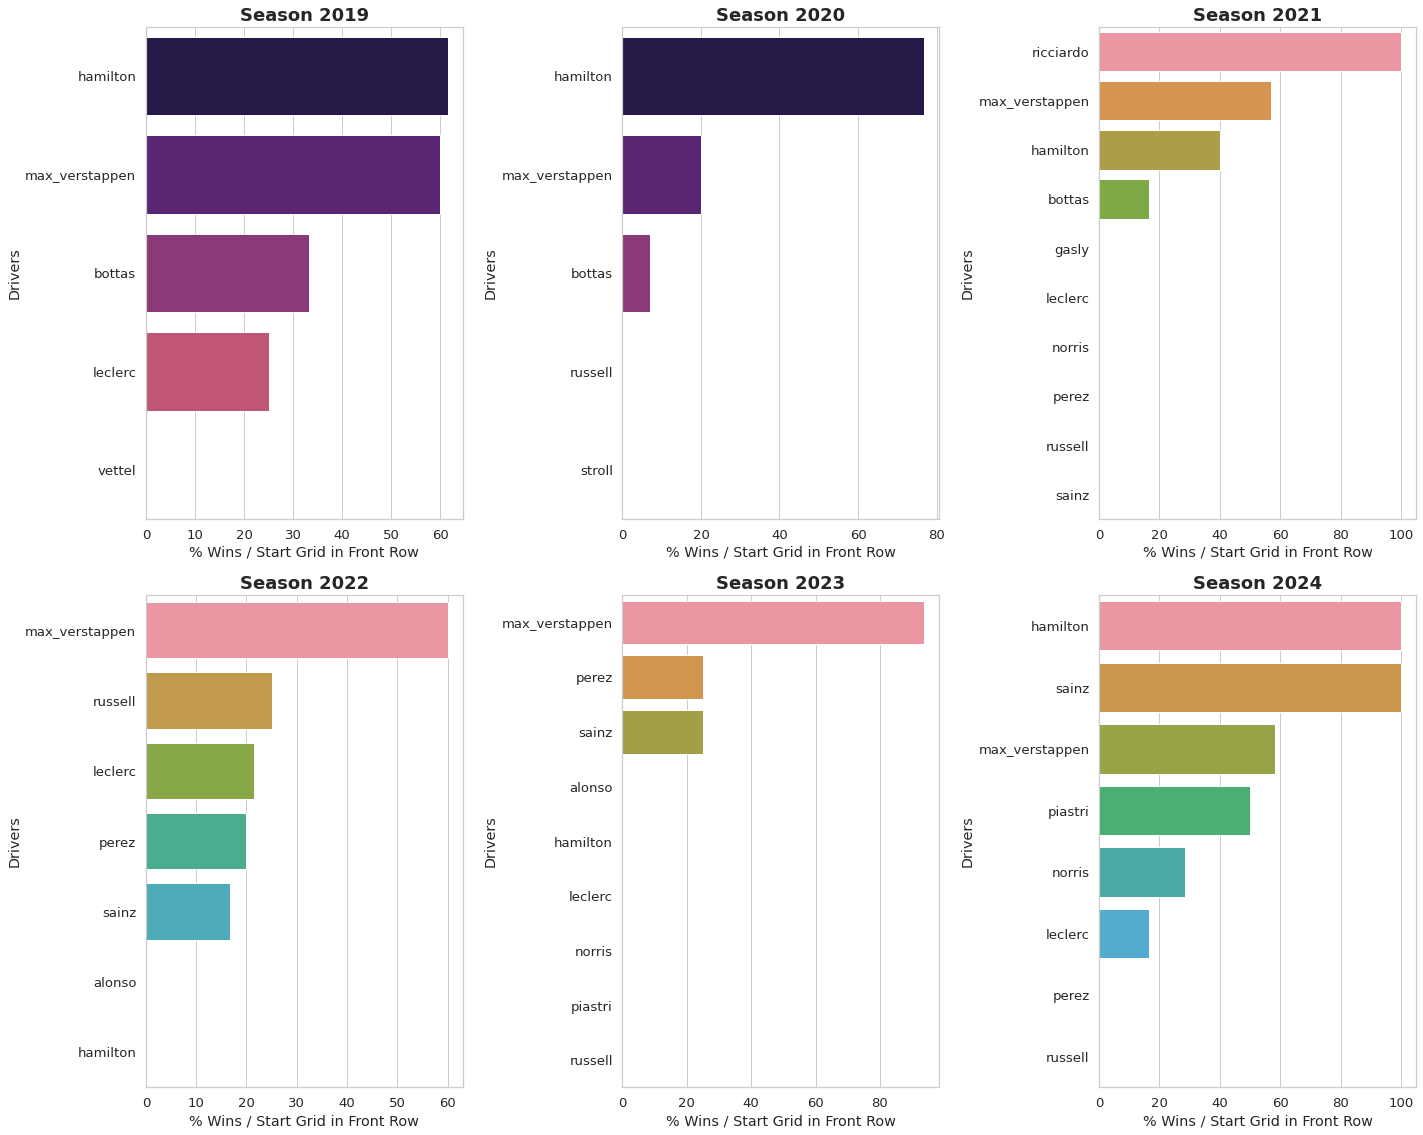

In [23]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019

DF1=ResultsDF[(ResultsDF['final_grid'].isin([1,2]))&(ResultsDF["season"]>=From_Season)].groupby(["driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"FrontRowTimes"})
DF2=ResultsDF[(ResultsDF['final_grid'].isin([1,2]))&(ResultsDF['final_position'].isin([1]))&(ResultsDF["season"]>=From_Season)].groupby(["driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Wins"})
DF=DF1.merge(DF2,on=["driverid","season"],how="left")
DF["%_Wins_Over_Front_Rows"]=np.round(DF["Wins"].fillna(0)*100/DF["FrontRowTimes"],1)

cols,x,y=3,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(20, rows*8),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    sns.barplot(y='driverid', x='%_Wins_Over_Front_Rows', data=DF[DF["season"] == year].sort_values(by="%_Wins_Over_Front_Rows",ascending=False), ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_ylabel('Drivers')
    axs[y,x].set_xlabel('% Wins / Start Grid in Front Row')

    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()


##### >>> % of Finish Podium Positions When Starting from the First 3 Positions in the Grid

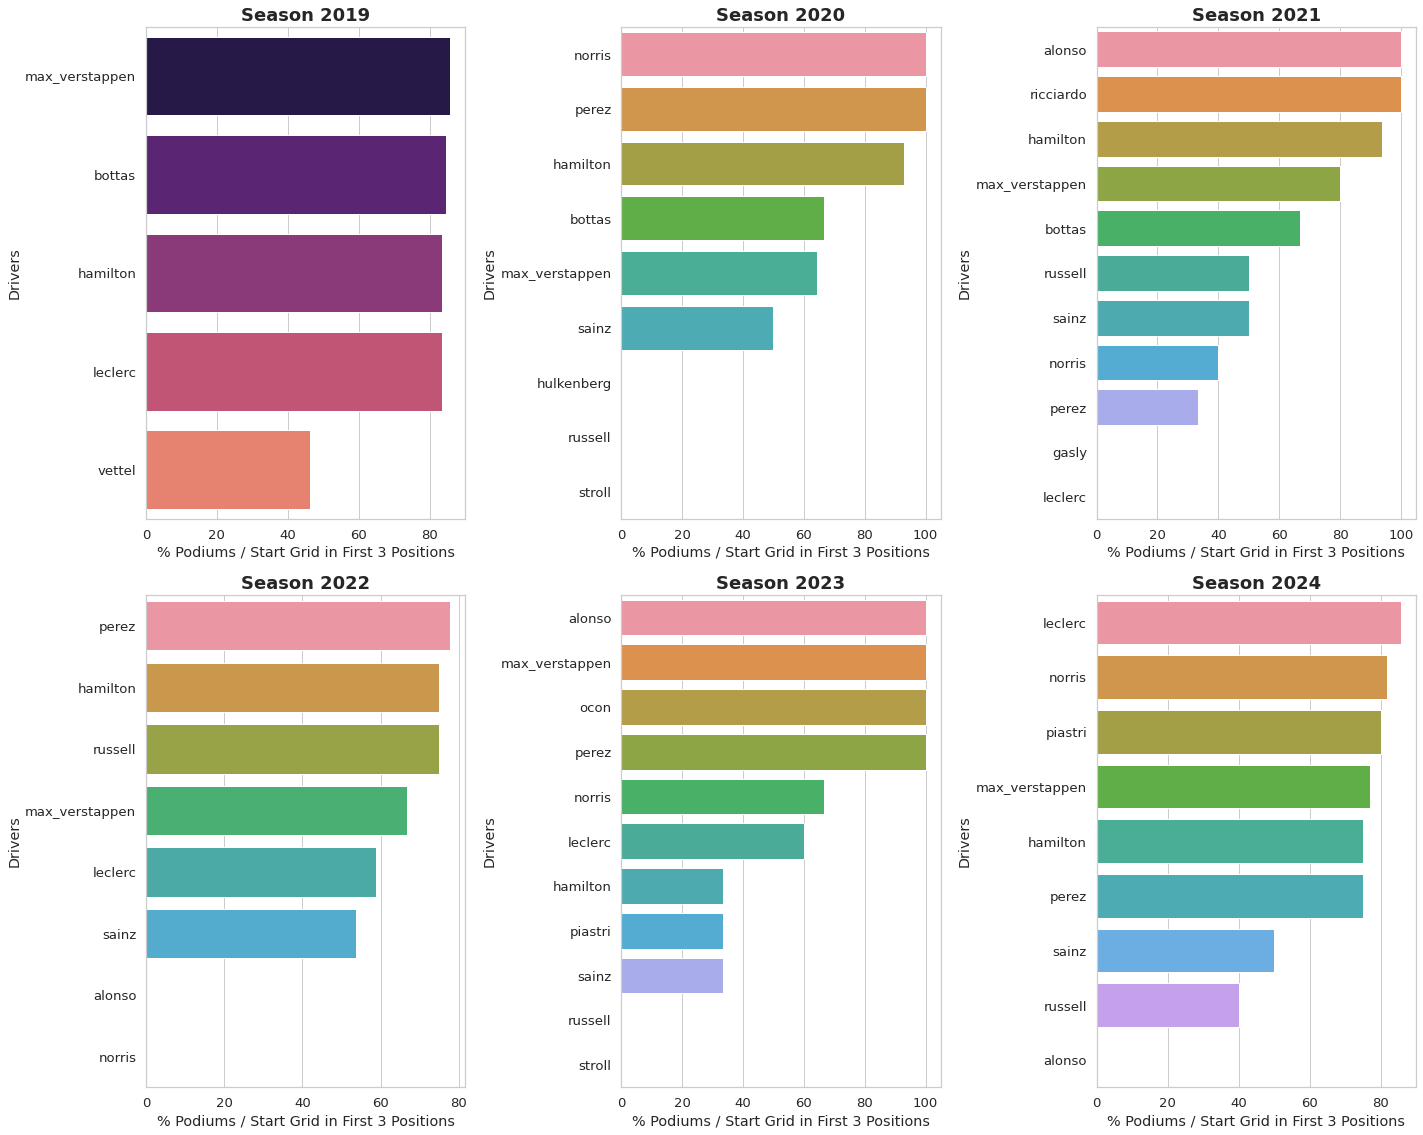

In [24]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

From_Season=2019

DF1=ResultsDF[(ResultsDF['final_grid'].isin([1,2,3]))&(ResultsDF["season"]>=From_Season)].groupby(["driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"FrontRowTimes"})
DF2=ResultsDF[(ResultsDF['final_grid'].isin([1,2,3]))&(ResultsDF['final_position'].isin([1,2,3]))&(ResultsDF["season"]>=From_Season)].groupby(["driverid","season"]).agg({"driver_number":"count"}).reset_index().rename(columns={"driver_number":"Wins"})
DF=DF1.merge(DF2,on=["driverid","season"],how="left")
DF["%_Wins_Over_Front_Rows"]=np.round(DF["Wins"].fillna(0)*100/DF["FrontRowTimes"],1)

cols,x,y=3,0,0
rows=int(np.ceil(DF["season"].nunique()/cols))

fig, axs = plt.subplots(figsize=(20, rows*8),ncols=cols,nrows=rows)

for year in sorted(DF["season"].unique()):
    sns.barplot(y='driverid', x='%_Wins_Over_Front_Rows', data=DF[DF["season"] == year].sort_values(by="%_Wins_Over_Front_Rows",ascending=False), ax=axs[y,x])
    axs[y,x].set_title(f'Season {year}',fontsize=18,fontweight='bold')
    axs[y,x].set_ylabel('Drivers')
    axs[y,x].set_xlabel('% Podiums / Start Grid in First 3 Positions')
    x+=1
    if x>cols-1:
        x=0
        y+=1

plt.tight_layout()
plt.show()
